In [31]:
import pandas as pd
import seaborn as sns

dc_wards_housing = pd.read_csv('../data/ACS_Housing_Characteristics_DC_Ward.csv')
dc_wards_social = pd.read_csv('../data/ACS_Social_Characteristics_DC_Ward.csv').loc[:,['DP02_0151E','DP02_0152E','DP02_0153E','WARD']]

dc_wards_housing.set_index('WARD', inplace=True)
dc_wards_social.set_index('WARD', inplace=True)


dc_wards = dc_wards_housing.join(dc_wards_social)
dc_wards

,OBJECTID,STATEFP,SLDUST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,...,DP04_0140E,DP04_0141E,DP04_0142E,DP04_0143E,GIS_ID,SHAPEAREA,SHAPELEN,DP02_0151E,DP02_0152E,DP02_0153E
WARD,,,,,,,,,,,,,,,,,,,,,
4,1,11,4,11004,Ward 4,L1,2018,G5210,N,23013646,...,1507,1166,4328,649,ACS_Housing_DC_Ward_4,0,0,30675,27621,25084
3,2,11,3,11003,Ward 3,L1,2018,G5210,N,26946477,...,1853,1484,5720,840,ACS_Housing_DC_Ward_8,0,0,37623,36297,34918
5,3,11,5,11005,Ward 5,L1,2018,G5210,N,26400212,...,2310,1559,7104,1263,ACS_Housing_DC_Ward_5,0,0,34896,30509,27121
1,4,11,1,11001,Ward 1,L1,2018,G5210,N,6383542,...,3484,2084,6094,902,ACS_Housing_DC_Ward_7,0,0,35796,33761,31113
2,5,11,2,11002,Ward 2,L1,2018,G5210,N,16573627,...,2746,2114,7296,1094,ACS_Housing_DC_Ward_1,0,0,37598,36618,34243
7,6,11,7,11007,Ward 7,L1,2018,G5210,N,21762801,...,1898,1346,7919,1865,ACS_Housing_DC_Ward_6,0,0,30877,25865,20367
6,7,11,6,11006,Ward 6,L1,2018,G5210,N,14830614,...,3512,2577,7648,1063,ACS_Housing_DC_Ward_3,0,0,46264,43850,41223
8,8,11,8,11008,Ward 8,L1,2018,G5210,N,22429470,...,2096,1768,12164,1818,ACS_Housing_DC_Ward_2,0,0,30657,26411,20901


In [32]:
dc_wards_social

,DP02_0151E,DP02_0152E,DP02_0153E
WARD,,,
4,30675,27621,25084
3,37623,36297,34918
5,34896,30509,27121
1,35796,33761,31113
2,37598,36618,34243
6,46264,43850,41223
8,30657,26411,20901
7,30877,25865,20367


For this example, using the following columns from the ACS housing data in order to derive as predictors:
* number of housing units in ward - `DP04_0006E`
* number of housing units in ward in a 20 or more unit complex - `DP04_0013E`
* number of occupied units - `DP04_0057E`
* number of occupied units without an available vehicle - `DP04_0058E`

As well as the following columns from the ACS social data:
* number of households reporting on broadband/computer access - `DP02_0151E`
* number of households with broadband internet - `DP02_0153E`
* number of households with a computer - `DP02_0152E`

We will predict the percentage of renters spending more than 35% of their income on rent:
* number of occupants paying rent - `DP04_0126E`
* number of occupants whose rent exceeds 35% of income - `DP04_0142E`

In [33]:
dc_wards = dc_wards.loc[:,['DP04_0006E', 'DP04_0013E', 'DP04_0057E',
    'DP04_0058E', 'DP04_0126E', 'DP04_0142E', 'DP02_0151E','DP02_0152E','DP02_0153E']]
dc_wards.head(8)

,DP04_0006E,DP04_0013E,DP04_0057E,DP04_0058E,DP04_0126E,DP04_0142E,DP02_0151E,DP02_0152E,DP02_0153E
WARD,,,,,,,,,
4,33459,7210,30675,6635,12149,4328,30675,27621,25084
3,40665,21885,37623,8457,17140,5720,37623,36297,34918
5,38521,6980,34896,10792,18187,7104,34896,30509,27121
1,39068,20250,35796,16378,22359,6094,35796,33761,31113
2,42701,29486,37598,18831,23227,7296,37598,36618,34243
7,34727,2666,30877,11848,17897,7919,30877,25865,20367
6,51191,22852,46264,15440,27794,7648,46264,43850,41223
8,34844,3813,30657,13620,23212,12164,30657,26411,20901


In [34]:
ward_pct = pd.concat([dc_wards.loc[:,'DP04_0013E'] / dc_wards.loc[:,'DP04_0006E'],
                     dc_wards.loc[:,'DP04_0058E'] / dc_wards.loc[:,'DP04_0057E'],
                     dc_wards.loc[:,'DP04_0142E'] / dc_wards.loc[:,'DP04_0126E'],
                     dc_wards.loc[:,'DP02_0152E'] / dc_wards.loc[:,'DP02_0151E'],
                     dc_wards.loc[:,'DP02_0153E'] / dc_wards.loc[:,'DP02_0151E']], axis='columns')\
                     .rename(columns={0:'Pct_20+Complex',
                                      1:'Pct_NoVehicle',
                                      2:'Pct_Rent35%orMore',
                                      3:'Pct_AccessToComputer',
                                      4:'Pct_AccessToBroadband'})

In [35]:
ward_pct

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore,Pct_AccessToComputer,Pct_AccessToBroadband
WARD,,,,,
4,0.215488,0.216300,0.356243,0.900440,0.817734
3,0.538178,0.224783,0.333722,0.964756,0.928102
5,0.181200,0.309262,0.390609,0.874284,0.777195
1,0.518327,0.457537,0.272552,0.943150,0.869175
2,0.690522,0.500851,0.314117,0.973935,0.910767
7,0.076770,0.383716,0.442476,0.837679,0.659617
6,0.446407,0.333737,0.275167,0.947821,0.891038
8,0.109431,0.444270,0.524039,0.861500,0.681769


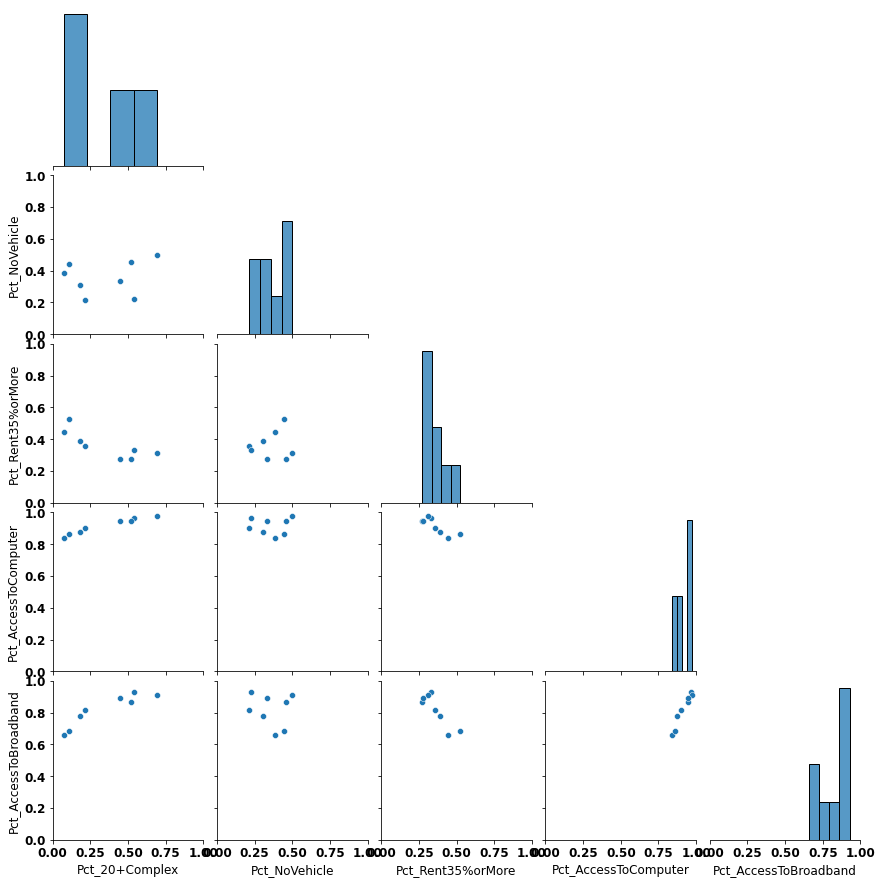

In [36]:
pair = sns.pairplot(ward_pct, corner=True)
pair.set(xlim=(0,1), ylim=(0,1)) 

### Example One - Supervised Learning

First step - in order to evaluate our model, we need to split the dataset into a 'train' and 'test' dataset. The training set will be used to optimize the model to make accurate predictions, but since they were used to create the model itself, they aren't particularly useful for determining whether the model is actually useful for anything. In order to do that, we need to show the model new observations that it hasn't seen yet - the 'test' set. 

In the real world, we would not be training a model on so few observations (8 observations are insufficient to make any sort of useful prediction) - but we will do so here for ease of understanding. 

In [37]:
import sklearn
from sklearn.model_selection import train_test_split

# all this function does is choose 25% of the data at random to be test data, and 75% to be training data
# functionally equivalent to just throwing all 8 observations in a bag and choosing 2 and 6, respectively
ward_train, ward_test = train_test_split(ward_pct, test_size=.25, train_size=.75, random_state=10) #

Training data:

In [38]:
ward_train

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore,Pct_AccessToComputer,Pct_AccessToBroadband
WARD,,,,,
6,0.446407,0.333737,0.275167,0.947821,0.891038
8,0.109431,0.444270,0.524039,0.861500,0.681769
4,0.215488,0.216300,0.356243,0.900440,0.817734
2,0.690522,0.500851,0.314117,0.973935,0.910767
7,0.076770,0.383716,0.442476,0.837679,0.659617
3,0.538178,0.224783,0.333722,0.964756,0.928102


Test data:

In [39]:
ward_test

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore,Pct_AccessToComputer,Pct_AccessToBroadband
WARD,,,,,
5,0.181200,0.309262,0.390609,0.874284,0.777195
1,0.518327,0.457537,0.272552,0.943150,0.869175


In [40]:
#now we train the linear regressor using the training data
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

ward_test.loc[:,'Data type'] = 'Test data'
ward_train.loc[:,'Data type'] = 'Training data'
ward_pct = pd.concat([ward_train, ward_test], axis = 'rows')
ward_pct.to_csv('ward_data_combined.csv')

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [41]:
ward_pct

,Pct_20+Complex,Pct_NoVehicle,Pct_Rent35%orMore,Pct_AccessToComputer,Pct_AccessToBroadband,Data type
WARD,,,,,,
6,0.446407,0.333737,0.275167,0.947821,0.891038,Training data
8,0.109431,0.444270,0.524039,0.861500,0.681769,Training data
4,0.215488,0.216300,0.356243,0.900440,0.817734,Training data
2,0.690522,0.500851,0.314117,0.973935,0.910767,Training data
7,0.076770,0.383716,0.442476,0.837679,0.659617,Training data
3,0.538178,0.224783,0.333722,0.964756,0.928102,Training data
5,0.181200,0.309262,0.390609,0.874284,0.777195,Test data
1,0.518327,0.457537,0.272552,0.943150,0.869175,Test data


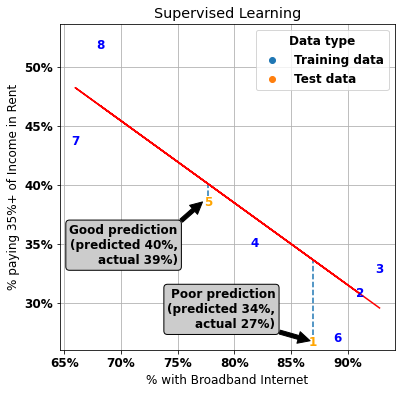

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
lin_reg.fit(ward_train.loc[:,['Pct_AccessToBroadband']], ward_train.loc[:,['Pct_Rent35%orMore']])

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(x = 'Pct_AccessToBroadband', y = 'Pct_Rent35%orMore', hue = 'Data type', data = ward_pct, alpha=0)
plt.plot(ward_train.loc[:,['Pct_AccessToBroadband']], lin_reg.predict(ward_train.loc[:,['Pct_AccessToBroadband']]), color='red')

x_actual = ward_test.loc[:,['Pct_AccessToBroadband']]
y_actual = ward_test.loc[:,['Pct_Rent35%orMore']]
y_predicted = lin_reg.predict(ward_test.loc[:,['Pct_AccessToBroadband']])

plt.vlines(x = x_actual,
           ymin = y_actual,
           ymax = y_predicted,
           linestyles='dashed')
plt.xlabel('% with Broadband Internet')
plt.ylabel('% paying 35%+ of Income in Rent')
plt.title('Supervised Learning')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

for idx, xy in enumerate(zip(ward_pct.loc[:,'Pct_AccessToBroadband'],
                             ward_pct.loc[:,'Pct_Rent35%orMore'])):
    if ward_pct['Data type'].iloc[idx] == 'Training data':
        col = 'blue'
    else:
        col = 'orange'
    ax.annotate(ward_pct.index[idx], xy=xy, textcoords='data', ha ='center', va = 'top', color = col) 

ax.annotate('Good prediction\n(predicted 40%,\nactual 39%)',
            xy=(x_actual.iloc[0]-.005, y_actual.iloc[0]-.005), xycoords='data',
            xytext=(-25, -65), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('Poor prediction\n(predicted 34%,\nactual 27%)',
            xy=(x_actual.iloc[1]-.002, y_actual.iloc[1]-.005), xycoords='data',
            xytext=(-35, 10), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='bottom')
plt.grid(which = 'both')
plt.savefig('Supervised.png', bbox_inches="tight")

plt.show()

### Example 2: Unsupervised Learning 

In [43]:
from sklearn import cluster

k_mean = cluster.KMeans(n_clusters = 2, random_state=450)
ward_pct.loc[:,'Cluster'] = k_mean.fit_predict(ward_pct.loc[:,['Pct_20+Complex','Pct_AccessToBroadband']])
ward_pct['Cluster'].replace({0 : 'Dense housing\n- more broadband',
                             1 : 'Sparse housing\n- less broadband'}, inplace=True)

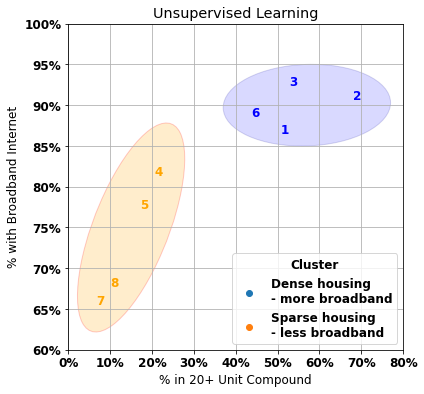

In [44]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize = (6,6))

sns.scatterplot(x = 'Pct_20+Complex', y = 'Pct_AccessToBroadband', hue = 'Cluster', data = ward_pct, alpha=0)

plt.xlabel('% in 20+ Unit Compound')
plt.ylabel('% with Broadband Internet')
plt.title('Unsupervised Learning')
plt.legend(loc = 'lower right', title = 'Cluster')
ax.set(xlim = (0,.8), ylim = (.6, 1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

for idx, xy in enumerate(zip(ward_pct.loc[:,'Pct_20+Complex'],
                             ward_pct.loc[:,'Pct_AccessToBroadband'])):
    if ward_pct['Cluster'].iloc[idx] == 'Dense housing\n- more broadband':
        col = 'blue'
    else:
        col = 'orange'
    ax.annotate(ward_pct.index[idx], xy=xy, textcoords='data', ha ='center', va = 'center', color = col) 


ax.add_patch(patches.Ellipse((.57,.9), .4, .1, angle = .9, facecolor = 'blue', alpha = .15, edgecolor = 'darkblue', linewidth = 1))
tst = patches.Ellipse((.15,.75), .33, .15, 90, facecolor = 'orange', alpha = .2, edgecolor = 'red', linewidth = 1)
t2 = matplotlib.transforms.Affine2D().rotate_deg_around(.15, .75, -45) + ax.transData
tst.set_transform(t2)
ax.add_patch(tst)


plt.grid(which = 'both')
plt.savefig('Unsupervised.png', bbox_inches="tight")

plt.show()